# Робота №2. Температурна залежність амплітуди коливань атомів у вузлах кристалічної ґратки

## Мета роботи
Визначити амплітуду коливань атомів металів методом молекулярної динаміки при різних
температурах.

## Об'єкт дослідження
Чисті метали за умов різних температур.

## Устаткування, прилади та матеріали

In [24]:
import pandas as pd # reading data
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['axes.grid'] = True

## Програма проведення експерименту

В програмі XMD створити кристал з ~1000-2000 атомів з періодичними граничними
умовами. Матеріал: _Pt_. Використовуємо наступний код:

In [3]:
%%writefile in.xm
read ../pot/Pt_xmd.eam

box 7 7 7

fill particle 4
1     0.0        0.0        0.0
1     0.5        0.0        0.5
1     0.5        0.5        0.0
1     0.0        0.5        0.5

fill align 7 7 7
fill orient 1 0 0  0 1 0  0 0 1
fill go

dtime 3.5e-15

select all #
mass 195.084

clamp $1
itemp $1
scale 3.9231

select index 685
set add 1
select keep on

repeat 400
	cmd 10
	select set 1
	write file +./out/T_$1K.posvel sel posvel
	#write pdb +lab2.pdb
end

Overwriting in.xm


Релаксуємо кристал при різних температурах: $T = 30~K, 300~K, 0.7~T_{пл}$.

In [5]:
temp_list = [30, 300, 1428]  # температури

In [ ]:
for i in temp_list:
    !del /f ./out/T_{i}K.posvel
    !xmd in.xm {i} > exp_T_{i}.log

Імпортуємо координати атома для кожної з температур.

In [6]:
coord_data = pd.DataFrame()
for temp in temp_list:
    coord_data[temp] = pd.read_csv(f"./out/T_{temp}K.posvel", 
                                   delimiter=' ',
                                   names=['n', 'x', 'y', 'z', 'vx', 'vy', 'vz'],
                                   comment='P',
                                   skipinitialspace=True)['x'] # writing x-coordinate of each temperature dataframe
    
coord_data.head()

,30,300,1428
0,11.765702,11.757866,11.744147
1,11.764596,11.753797,11.733007
2,11.767818,11.762838,11.746854
3,11.775414,11.786534,11.791334
4,11.785089,11.818284,11.855723


Аналізуємо координати атому: будуємо графік $X=f(t)$.

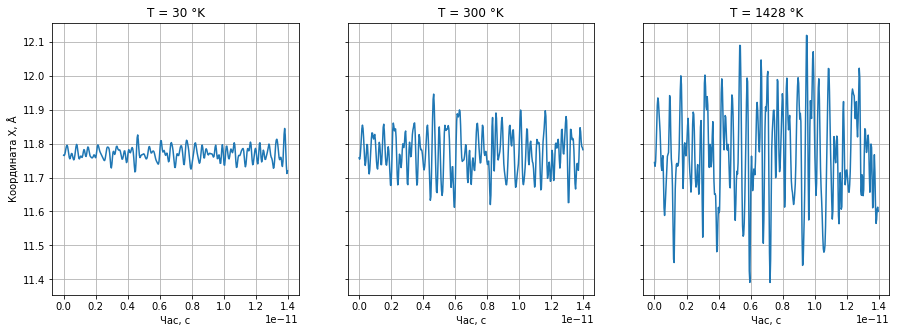

In [7]:
coord_data['time'] = coord_data.index * (3.5e-15 * 10)  # перетворюємо індекси в час

f, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(15,5))

it = iter([0, 1, 2])
for T in temp_list:
    n = next(it)
    axes[n].plot(coord_data.time, coord_data[T])
    axes[n].set_title(f"T = {T} °K")
    axes[n].set_xlabel(r"Час, с")
axes[0].set_ylabel("Координата Х, Å")

В статистиці по стовпчикам знаходимо середньоквадратичне відхилення (std) атомів:

In [8]:
stds = coord_data[temp_list].std()
df_std = pd.DataFrame(stds, columns={'Амплітуда коливань, Å':0})
df_std.index.name='Температура, К'
df_std.round(4)

,"Амплітуда коливань, Å"
"Температура, К",
30,0.0197
300,0.0620
1428,0.1402


Побудувати залежність амплітуди коливань з екстраполяцією від температури $0~K$ до $T_{пл}$.

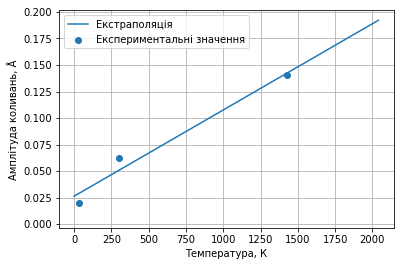

In [23]:
# масив температур для екстраполяції
new_temp = np.arange(0, 2041, 5)

# екстраполюємо амплітуди
fit_std = np.polyfit(temp_list, stds, 1)
line_std = np.poly1d(fit_std)
new_std = line_std(new_temp)

plt.scatter(temp_list, stds, label='Експериментальні значення')
plt.plot(new_temp, new_std, label='Екстраполяція')
plt.legend()
plt.ylabel('Амплітуда коливань, Å')
plt.xlabel('Температура, К')

Порівняти амплітуду коливань з міжатомною відстанню у відсотках при $T_{пл}$.

In [10]:
latt = 3.9242 # Angstrom
inter_distance = latt * np.sqrt(3) / 2

print(f"Міжатомна відстань: {round(inter_distance, 4)} Å.")
df_std[r'Відношення до міжатомної відстані, %'] = stds / inter_distance * 100
df_std.round({df_std.columns[0]:4, df_std.columns[1]:1})

Міжатомна відстань: 3.3985 Å.


,"Амплітуда коливань, Å","Відношення до міжатомної відстані, %"
"Температура, К",,
30,0.0197,0.6
300,0.0620,1.8
1428,0.1402,4.1


Можливість дифузії та утворення вакансій за таких умов неможлива. Але такий висновок суперечить експериментальним даним. Така розбіжність виникає через те, що концентрація вакансії має ~-10 порядок (1 вакансія на $10^{10}$ атомів). В даній роботі був змодельований кристал з 2000 атомів, тому така модель не призначена для дослідження утворення вакансій.

Оцінити період коливань атомів для різних температур.

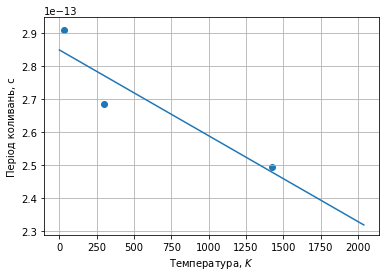

In [11]:
# розраховуємо періоди
counts = np.array([48, 52, 56])
periods = coord_data.time.iloc[-1] / counts

# екстраполюємо їх
fit_per = np.polyfit(temp_list, periods, 1)
line_per = np.poly1d(fit_per)
new_per = line_per(new_temp)

# побудова графіків
plt.plot(new_temp, new_per, label='Екстраполяція')
plt.scatter(temp_list, periods, label='Експериментальні значення')
plt.ylabel('Період коливань, с')
plt.xlabel(r'Температура, $K$')
plt.show()
plt.clf()